In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import time
from scipy.stats import laplace, norm, rayleigh
from scipy.optimize import curve_fit
#from scipy.stats import norm

%matplotlib inline

In [2]:
deltatimes = pd.read_csv("../csvs/resonant/deltatimes.csv")
deltatimes.head()


,ID,t,t_shadow
0,0.0,5.330628e+03,9.377841e+03
1,1.0,9.999999e+07,9.999999e+07
2,2.0,9.999999e+07,9.999999e+07
3,3.0,5.946887e+06,3.941298e+06
4,4.0,3.711381e+05,6.345772e+05


In [3]:
scores = pd.read_csv("../csvs/resonant/significance_scores.csv")

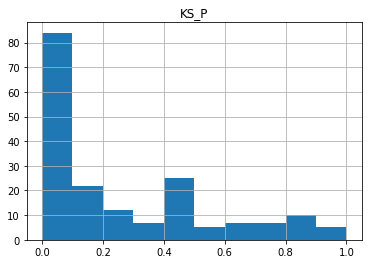

173


In [4]:
scores.hist("KS_P")
plt.show()
print (len(np.where(scores["KS_P"]>1e-6)[0]))
res_keep = scores[scores["KS_P"]>1e-6]
# interesting how we retain 173 out of 184 with the same cut
# we retain a significantly higher proportion, about 94% compared to with the randomly generated systems

In [5]:
#pull up gaussian fits, and the P value significance, to take all systems with above 1-e6.
#this is a reasonable threshold because higher than that removes many systems, and lower than that includes many odd systems
info = pd.read_csv("../csvs/resonant/Gaussian_Fits_317.csv")

In [6]:
trimmed = deltatimes[(deltatimes["t"]<1e7) & (deltatimes["t"]>1e4)
                    & (deltatimes["t_shadow"]<1e7)& (deltatimes["t_shadow"]>1e4)]
trimmed.shape

(184, 3)

In [7]:
trimmed_ids = trimmed["ID"].values
print (trimmed_ids[:4], type(trimmed_ids[0]), type(info.loc[0]["ID"]))
trimmed_info = info.loc[ info["ID"].isin(trimmed_ids) ]
print (trimmed_info.shape)

[3. 4. 5. 8.] <class 'numpy.float64'> <class 'numpy.float64'>
(184, 7)


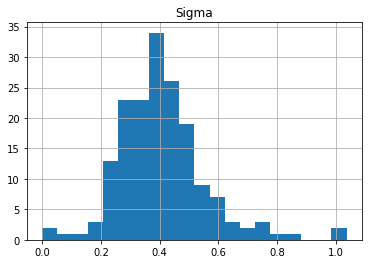

In [8]:
valid_gaus_params= trimmed_info[trimmed_info["ID"].isin((res_keep["ID"]).values)]
valid_gaus_params.hist("Sigma", bins = 20)
plt.show()

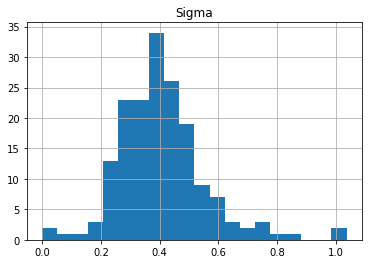

In [9]:
valid_gaus_params = trimmed_info[trimmed_info["ID"].isin((res_keep["ID"]).values)]
valid_gaus_params.hist("Sigma", bins = 20)
plt.show()

Average Sigma 0.40734287402647257 Std in Sigma 0.1486734452165868
Max valid sigma 1.035940966917217


/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/pandas/plotting/_core.py:2410: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)


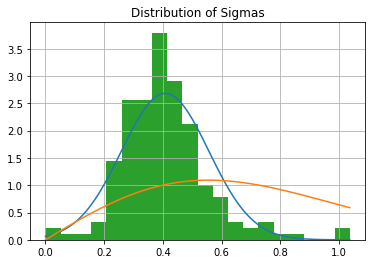

In [10]:
mu_fit, sig_fit =  norm.fit(valid_gaus_params["Sigma"].values)
print ("Average Sigma", mu_fit, "Std in Sigma", sig_fit)
mu_r, sig_r = rayleigh.fit(valid_gaus_params['Sigma'].values)

fig = plt.figure()
ax = fig.add_subplot("111")
x = np.linspace(0, valid_gaus_params["Sigma"].max(), 100)
prob_sig = norm.pdf(x, mu_fit, sig_fit)
prob_r = rayleigh.pdf(x, loc=0, scale=0.555)
plt.plot(x, prob_sig)
plt.plot(x, prob_r)
valid_gaus_params.hist("Sigma", normed = 1, ax = ax, bins = 20)

print("Max valid sigma", valid_gaus_params["Sigma"].max())
plt.title("Distribution of Sigmas")
plt.show()

In [11]:
mu_r, sig_r

(-0.004000172547314939, 0.30930727217735343)

In [12]:
norm_prob_sig = prob_sig/(prob_sig.sum())

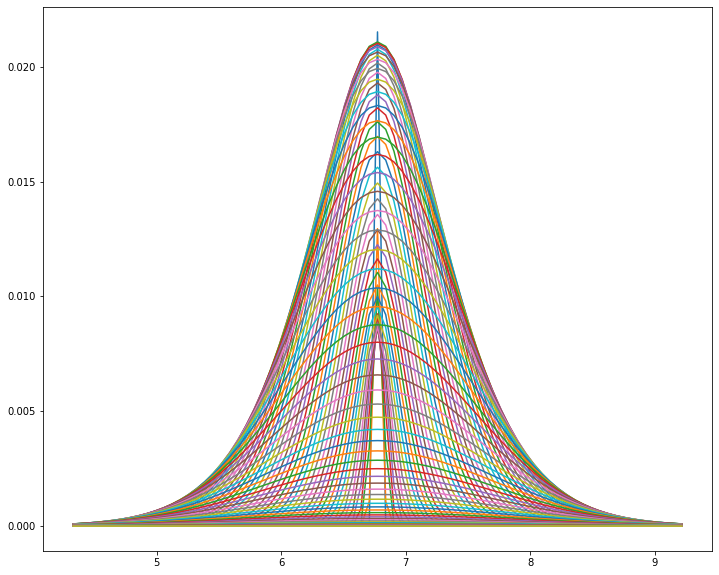

In [13]:
# Analytically over each of the mu;s, how to combine the sigmas?
max_sigma = mu_fit # the center of the distribution
increments = 75

plt.figure(figsize=(12, 10))


total_y= np.zeros(increments)
for j in range(1,int(prob_sig.shape[0]), 1):
    fixed_sigma=x[j]
    t_sim = np.log10(trimmed["t"].values[0])
    bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
    final_y = norm.pdf(bins, t_sim, fixed_sigma*2**0.5)* norm_prob_sig[j]       
    total_y +=final_y
    plt.plot(bins, final_y )

end = time.time()
plt.show()

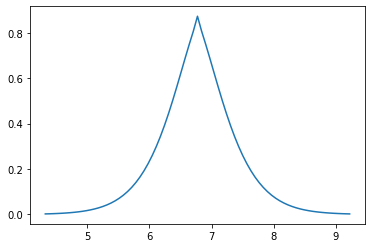

In [14]:
bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
plt.plot(bins, total_y)
width = (12*max_sigma)/(increments-1)
plt.show()

The laplace distribution has a mean of $\mu$, and a varience of $2b^2$.  P(x) = $\frac{1}{2b}exp(\frac{-|x-\mu|}{b})$

In [15]:
def laplace_fit(data, mean, spread):
    return np.exp(-np.abs(data-mean)/spread)/2./spread

[6.76823708 0.52123104]
[0.00516219 0.00728107]
params [0.         0.52123104]


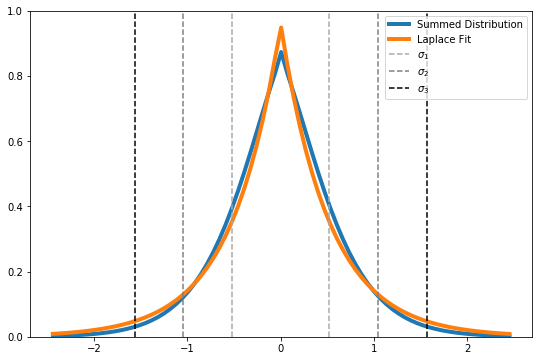

In [16]:
# Function for optimizing the difference between total_Y(graph from)

plt.figure (figsize=(9, 6))
popt, pcov = curve_fit(laplace_fit, bins, total_y)
print (popt)
perr = np.sqrt(np.diag(pcov))
print (perr)

# center distribution, as we're currently only interested in the spread
bins -= popt[0]
popt[0] = 0

plt.plot(bins, total_y, label = "Summed Distribution", linewidth = 4)
print("params", popt)


plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 4)


colors = ["darkgrey","grey", "black"]
for i in range(1,4):
    plt.axvline(popt[0]+i*popt[1], ls= "dashed", label = "$\sigma_{0}$".format(i), color = colors[i-1])
    plt.axvline(popt[0]-i*popt[1], ls= "dashed", color = colors[i-1])
plt.legend()
plt.ylim([0,1])
plt.show()

In [17]:
#try testing with the resonant dataset
res_test = pd.read_csv("../csvs/resonant/resonant_instability_times.csv", index_col=0)
res_test.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom,instability_time,shadow_instability_time
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669,1.545872e+06,3.063700e+06
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656,9.990000e+08,9.990000e+08
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319,9.990000e+08,9.990000e+08
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200,2.287671e+06,8.392234e+06
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803,9.668931e+05,3.380350e+05


In [18]:
test_samples = res_test[ (np.log10(res_test["instability_time"])<7 ) &
                       (np.log10(res_test["shadow_instability_time"])<7 ) &
                       (np.log10(res_test["instability_time"])>4 ) &
                       (np.log10(res_test["shadow_instability_time"])>4 ) ]
test_samples.shape

(5039, 10)

In [19]:
test_samples = res_test[ (np.log10(res_test["instability_time"])<7 ) &
                       (np.log10(res_test["instability_time"])>4.75 )]
test_samples.shape

(3831, 10)

(3831,)
(3736,)


/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


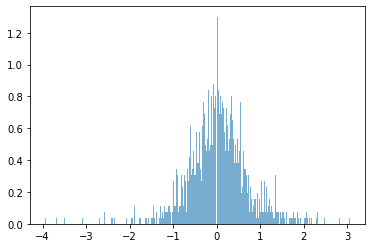

In [20]:
diff_data = np.log10(test_samples["instability_time"]) - np.log10(test_samples["shadow_instability_time"])
print(diff_data.shape)
diff_data= diff_data[np.abs(diff_data) > 1.e-2]
print(diff_data.shape)

a, b, c = plt.hist(diff_data, bins= 1000, normed=1, alpha = 0.6)


/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Laplacian params [0.         0.52123104]
Mean sig 0.40734287402647257


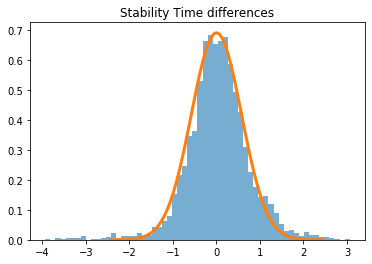

In [21]:
diff_data = np.log10(test_samples["instability_time"]) - np.log10(test_samples["shadow_instability_time"])
diff_data= diff_data[np.abs(diff_data) > 1.e-2]
plt.hist(diff_data, bins= 60, normed=1, alpha = 0.6)

#plot with laplace fit
#plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 3)
print("Laplacian params", popt[:])

#plot with gaussian with mean width
sig_plot = norm.pdf(bins, 0, mu_fit*np.sqrt(2))
print("Mean sig", mu_fit)
plt.plot(bins, sig_plot, linewidth = 3)
#plt.plot(bins, total_y, linewidth=3)
plt.title("Stability Time differences")
plt.show()


/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


Laplacian params [0.         0.52123104]
Mean sig 0.40734287402647257


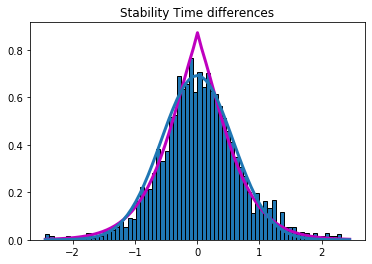

In [22]:
diff_data = np.log10(test_samples["instability_time"]) - np.log10(test_samples["shadow_instability_time"])
diff_data= diff_data[np.abs(diff_data) > 1.e-2]
frq, edges = np.histogram(diff_data, bins, normed=True)

plt.bar(edges[:-1], frq, width=np.diff(edges), ec="k", align="edge")
#vals, bins2, patches = plt.hist(diff_data, bins= 50, normed=1, alpha = 0.6)

#plot with laplace fit
#plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 3)
b=0.555
#plt.plot(bins, 1./2/b*np.exp(-np.abs(bins)/b), label = "Laplace Fit", linewidth = 3)
print("Laplacian params", popt[:])
plt.plot(bins, total_y, color='m', linewidth=3)

#plot with gaussian with mean width
sig_plot = norm.pdf(bins, 0, mu_fit*np.sqrt(2))
print("Mean sig", mu_fit)
plt.plot(bins, sig_plot, linewidth = 3)
plt.title("Stability Time differences")
plt.show()


Laplacian params [0.         0.52123104]
Mean sig 0.40734287402647257


/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


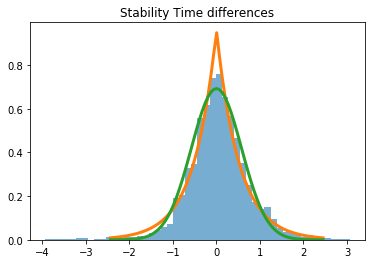

In [23]:
diff_data = np.log10(test_samples["instability_time"]) - np.log10(test_samples["shadow_instability_time"])
vals, bins2, patches = plt.hist(diff_data, bins= 50, normed=1, alpha = 0.6)

#plot with laplace fit
plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 3)
print("Laplacian params", popt[:])

#plot with gaussian with mean width
sig_plot = norm.pdf(bins, 0, mu_fit*np.sqrt(2))
print("Mean sig", mu_fit)
plt.plot(bins, sig_plot, linewidth = 3)
plt.title("Stability Time differences")
plt.show()


(array([   7.,  117.,  583., 1601., 2859., 2742., 1501.,  485.,   92.,
          13.]),
 array([ 625.36880425,  700.89435847,  776.41991268,  851.9454669 ,
         927.47102111, 1002.99657533, 1078.52212955, 1154.04768376,
        1229.57323798, 1305.09879219, 1380.62434641]),
 <a list of 10 Patch objects>)

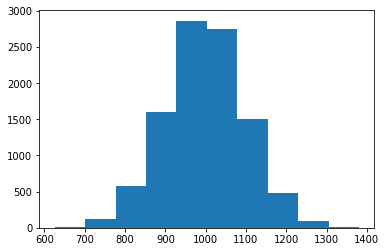

In [24]:
from scipy.stats import norm
rv = norm(loc=1000, scale=100)
vals = rv.rvs(size=10000)
fig,ax =plt.subplots()
ax.hist(vals)

In [25]:
vals.std()

98.8512580611535

In [26]:
rv = norm(loc=3, scale=0.4)
def sample(rv):
    vals = rv.rvs(size=2)
    return vals[1]-vals[0]

In [27]:
diffs = [sample(rv) for i in range(100000)]

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


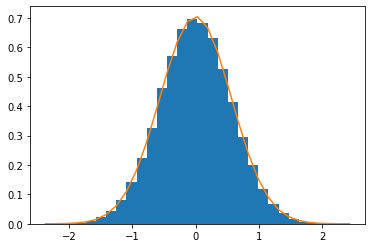

In [28]:
fig,ax =plt.subplots()
vals, bins, patches = ax.hist(diffs, bins=30, normed=True)
sig_plot = norm.pdf(bins, loc=0, scale=0.4*np.sqrt(2))
ax.plot(bins, sig_plot)

In [29]:
res_test = pd.read_csv("../csvs/resonant/resonant_instability_times.csv", index_col=0)
res_test.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom,instability_time,shadow_instability_time
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669,1.545872e+06,3.063700e+06
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656,9.990000e+08,9.990000e+08
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319,9.990000e+08,9.990000e+08
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200,2.287671e+06,8.392234e+06
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803,9.668931e+05,3.380350e+05


In [129]:
tmin = 6.
tmax = 8

In [130]:
res_samples = res_test[ (np.log10(res_test["instability_time"])<tmax ) &
                       (np.log10(res_test["shadow_instability_time"])<tmax ) &
                       (np.log10(res_test["instability_time"])>tmin ) &
                       (np.log10(res_test["shadow_instability_time"])>tmin ) ]
res_samples.shape

(1609, 10)

In [131]:
res_diffs = np.log10(res_samples["instability_time"]) - np.log10(res_samples["shadow_instability_time"])
#res_diffs= res_diffs[np.abs(res_diffs) > 1.e-2]
res_diffs.shape

(1609,)

In [132]:
rand_test = pd.read_csv("../csvs/random/deltatimes.csv", index_col=0)
rand_test.head()

,runstring,t,t_shadow
0,0000000.bin,1.235644e+07,8.315081e+07
1,0000001.bin,1.348749e+05,2.133072e+05
2,0000002.bin,1.276381e+04,9.321519e+03
3,0000003.bin,1.000000e+09,1.000000e+09
4,0000004.bin,8.791888e+01,8.791888e+01


In [133]:
rand_samples = rand_test[ (np.log10(rand_test["t"])<tmax ) &
                       (np.log10(rand_test["t_shadow"])<tmax ) &
                       (np.log10(rand_test["t"])>tmin ) &
                       (np.log10(rand_test["t_shadow"])>tmin ) ]
rand_samples.shape

(1825, 3)

In [134]:
rand_diffs = np.log10(rand_samples["t"]) - np.log10(rand_samples["t_shadow"])
#rand_diffs= rand_diffs[np.abs(rand_diffs) > 1.e-2]
rand_diffs.shape

(1825,)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


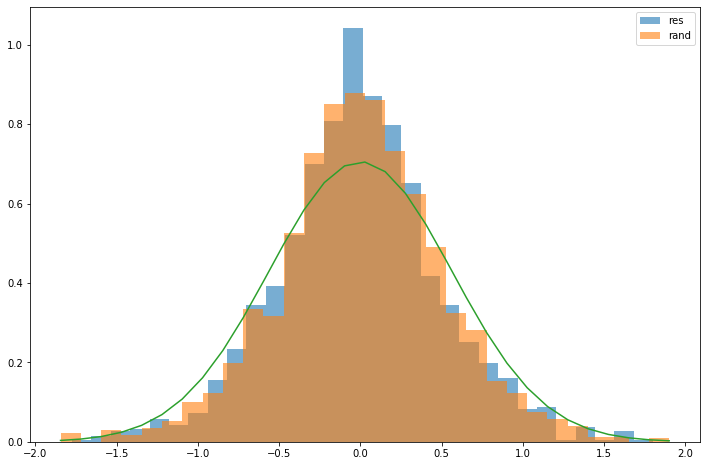

In [135]:
fig, ax = plt.subplots(figsize=(12,8))
a, b, c = ax.hist(res_diffs, bins= 30, normed=1, alpha = 0.6, label='res')
a, b, c = ax.hist(rand_diffs, bins= 30, normed=1, alpha = 0.6, label='rand')
sig_plot = norm.pdf(b, loc=0, scale=0.4*np.sqrt(2))
ax.plot(b, sig_plot)
ax.legend()

In [136]:
from scipy.stats import ks_2samp
ks_2samp(res_diffs, rand_diffs)

Ks_2sampResult(statistic=0.029677924687332387, pvalue=0.4276327324601774)